In [0]:
import pandas as pd
from pandas import Series, DataFrame, Panel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import sklearn
import scipy
import scipy.ndimage
import seaborn as sns
from PIL import Image
%matplotlib inline

In [2]:
!pip3 install pyro-ppl

     |████████████████████████████████| 430kB 8.9MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


# Загружаем данные

In [3]:
# Загружаем MNIST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

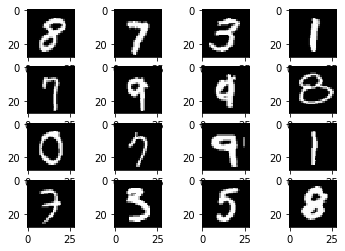

In [5]:
import scipy
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    #print(I.shape)
    plt.imshow(I, cmap='gray')
#(X[np.random.randint(0, X.shape[0]),0])

In [6]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)
Y_enc = np.zeros((len(Y), 10))
for i in range(len(Y)):
  Y_enc[i, Y[i]] = 1
Y_enc

original [5 0 4 ... 4 5 6]


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Определяем модели

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.autograd import Variable

class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module('conv_1', nn.Conv2d(1, 32, kernel_size=(3,3), stride=1))
        self.net.add_module('relu_1', nn.ReLU())
        self.net.add_module('conv_2', nn.Conv2d(32, 64, kernel_size=(3,3), stride=1)) 
        self.net.add_module('relu_2', nn.ReLU())
        self.net.add_module('drop_1', nn.Dropout(0.1))                  
        self.fc1 = nn.Linear(64*24*24, 128)
        self.drop2 = nn.Dropout()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, 64 * 24 * 24)
        x = self.fc2(self.drop2(F.relu(self.fc1(x))))
        return x

class SVINet(nn.Module):

    def __init__(self):
        super(SVINet, self).__init__()
        self.fc2 =  nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.fc2(x)
        return x
        
class MLPNet(nn.Module):

    def __init__(self):
        super(MLPNet, self).__init__()
        self.net = nn.Sequential()                 
        self.fc1 = nn.Linear(28*28, 200)
        self.drop2 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, 28*28)
        x = self.fc2(self.drop2(self.fc1(x)))
        x = F.relu(x)
        return x


## Функции обучения моделей и эксперименты

In [0]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss

def fit_net(c_epoch, net, X, Y):
    loss_fn = torch.nn.CrossEntropyLoss()

    learning_rate = 1e-4
    batch_size = 30
    # Оптимизатор
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_curve = []
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    net = net.train()
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X_train.shape[0])
        loss_acc = 0
        nbatches = X_train.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = Variable(torch.Tensor(X_train[batch_idxs]).to(DEVICE))
            y = Variable(torch.from_numpy(Y_train[batch_idxs]).long().to(DEVICE))
            y_pred = F.softmax(net(x), -1)
            loss = loss_fn(y_pred, y)
            loss_acc += float(loss.data)
            optimizer.zero_grad()        
            loss.backward()
            optimizer.step()    
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    return net

def experiment_vanilla(net, X, Y, rotate=False, translate=False, blur=False):

    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = net(x).cpu().detach().numpy()
            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
                y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], scipy.special.softmax(y_pred[i]))*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier
#plt.plot(loss_curve)

In [0]:
def experiment_ensemble(nets, X, Y, rotate=False, translate=False, blur=False):
    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    for i in range(len(nets)):
        nets[i] = nets[i].to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = np.zeros((batch_size, 10))
            for net in nets:
                y_pred += scipy.special.softmax(net(x).cpu().detach().numpy(), -1)
            y_pred /= len(nets)

            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
                y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], y_pred[i])*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier
#plt.plot(loss_curve)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro import optim
from pyro.infer import SVI, Trace_ELBO
import pyro
from pyro.nn import PyroModule
from pyro.nn import PyroSample
import pyro.distributions as dist

softplus = torch.nn.Softplus()
log_softmax = nn.LogSoftmax(dim=1)



def fit_pyro_net(c_epoch,  X, Y, learning_rate = 1e-4):

    net_ = SVINet()
    
    def model_(x_data, y_data):
      fc2w_prior = dist.Normal(loc=torch.zeros_like(net_.fc2.weight), scale=torch.ones_like(net_.fc2.weight))
      fc2b_prior = dist.Normal(loc=torch.zeros_like(net_.fc2.bias), scale=torch.ones_like(net_.fc2.bias))
      priors = {'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior}
      # lift module parameters to random variables sampled from the priors
      lifted_module = pyro.random_module("module", net_, priors)
      # sample a regressor (which also samples w and b)
      lifted_reg_model = lifted_module()
      lhat = log_softmax(lifted_reg_model(x_data))
      pyro.sample("obs", dist.Categorical(logits=lhat), obs=y_data)

    def guide_(x_data, y_data):
        
        # First layer weight distribution priors
        fc2w_mu = torch.randn_like(net_.fc2.weight)
        fc2w_sigma = torch.randn_like(net_.fc2.weight)
        fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
        fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", fc2w_sigma))
        fc2w_prior = dist.Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param)
        # First layer bias distribution priors
        fc2b_mu = torch.randn_like(net_.fc2.bias)
        fc2b_sigma = torch.randn_like(net_.fc2.bias)
        fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu)
        fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", fc2b_sigma))
        fc2b_prior = dist.Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param)
        priors = {'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior}
        lifted_module = pyro.random_module("module", net_, priors)
        
        return lifted_module()

    def predict(x):
        sampled_models = [guide_(None, None) for _ in range(10)]
        yhats = [mod(x).data for mod in sampled_models]
        mean = torch.mean(torch.stack(yhats), 0)
        return np.argmax(mean.numpy(), axis=1)

    def get_logits(x):
        sampled_models = [guide_(None, None) for _ in range(10)]
        yhats = [mod(x).data for mod in sampled_models]
        mean = torch.mean(torch.stack(yhats), 0)
        return mean.numpy()
  #  guide = AutoDiagonalNormal(net)

   # pyro.clear_param_store()
    adam_optimizer = optim.Adam({"lr": learning_rate})
    svi = SVI(model_, guide_, adam_optimizer, loss=Trace_ELBO())
    batch_size = 300
    loss_curve = []

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X_train.shape[0])
        loss_acc = 0
        acc = 0
        nbatches = X_train.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.from_numpy(X_train[batch_idxs].reshape(-1, 28*28)).float()
            y = Y_train[batch_idxs]
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
              y_enc[i, y[i]] = 1
            y = torch.from_numpy(y)
            y_enc = torch.from_numpy(y_enc)
            loss = svi.step(x, y)
      #      y_pred = predict(x)#.cpu().detach().numpy()
           # print(y_pred)
            y = Y_train[batch_idxs]
       #     acc += float(np.count_nonzero(y == y_pred))
       #     loss = loss_fn(y_pred, y)
            loss_acc += float(loss)   
        avg_epoch_loss = loss_acc / (nbatches)
       # avg_acc = acc / len(Y_train)
        
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
       # print('Do epoch %s with acc %s' % (iter, avg_acc ))
        loss_curve.append(avg_epoch_loss)
    return get_logits

In [0]:
def experiment_pyro(predict, X, Y, rotate=False, translate=False, blur=False):

    batch_size = 300
    X_train,  X_test,   Y_train, Y_test= train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ]
            if translate:
                x = torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter))
            if blur:
                x = torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1))
            x = x.reshape(-1, 28*28)
            y = Y_test[batch_idxs]
            y_pred = predict(x)
            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
              y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], scipy.special.softmax(y_pred[i]))*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier

In [0]:
def fit_net_T(c_epoch, net, X, Y):
    loss_fn = torch.nn.NLLLoss()
    learning_rate = 1e-4
    batch_size = 30
    # Оптимизатор
    
    loss_curve = []
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(DEVICE)
    
    class T_net(nn.Module):
        def __init__(self):
            super(T_net, self).__init__()
            self.T = nn.Parameter(torch.FloatTensor([1.]))
            
        def forward(self, x):
            return F.log_softmax(Variable(net(x))*self.T, -1)
    t_net = T_net().to(DEVICE)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    X_val, X_test, Y_val, Y_test = train_test_split(X_test,Y_test, test_size=0.7, random_state=97)
    optimizer = torch.optim.Adam(t_net.parameters(), lr=learning_rate)

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X_val.shape[0])
        loss_acc = 0
        nbatches = X_val.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = Variable(torch.Tensor(X_val[batch_idxs]).to(DEVICE))
            y = Variable(torch.from_numpy(Y_val[batch_idxs]).long().to(DEVICE))
            y_pred = t_net(x) # F.log_softmax(Variable(net(x))/T, -1)
            loss = loss_fn(y_pred, y)
            loss_acc += float(loss.data)
            optimizer.zero_grad()        
            loss.backward()
            optimizer.step()    
        avg_epoch_loss = loss_acc / (nbatches)
        print('T optimization: Do epoch %s with loss %s T = %s' % (iter, avg_epoch_loss, 1./t_net.T.data.item()))
        loss_curve.append(avg_epoch_loss)
    return t_net.T.data.item()

def experiment_temperature(net, X, Y, T, rotate=False, translate=False, blur=False):
    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = net(x).cpu().detach().numpy()
            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
                y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], scipy.special.softmax(y_pred[i]*T))*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier

In [0]:
def experiment_dropout(net, X, Y, n_iter=10, rotate=False, translate=False, blur=False):

    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = np.zeros((batch_size, 10))
            for it in range(n_iter):
                y_pred += scipy.special.softmax(net(x).cpu().detach().numpy(), -1)
            y_pred /= n_iter
            
            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
                y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], y_pred[i])*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier

# Обучаем модели


## Vanilla

In [14]:
net = LeNet()
net_v = fit_net(10, net, X, Y)
model_van = net_v.eval()
loss_curve_translate_vanilla , brier_curve_translate_vanilla = experiment_vanilla(model_van, X,Y, translate=True)
loss_curve_rotate_vanilla , brier_curve_rotate_vanilla = experiment_vanilla(model_van, X,Y, rotate=True)
loss_curve_blur_vanilla , brier_curve_blur_vanilla = experiment_vanilla(model_van, X,Y, blur=True)

Do epoch 0 with loss 1.6877246329766507
Do epoch 1 with loss 1.5110520273287324
Do epoch 2 with loss 1.4984639134948787
Do epoch 3 with loss 1.492655500146737
Do epoch 4 with loss 1.4894583657112408
Do epoch 5 with loss 1.486362911177857
Do epoch 6 with loss 1.4851298681026104
Do epoch 7 with loss 1.4823202053194773
Do epoch 8 with loss 1.4807420657250914
Do epoch 9 with loss 1.4798776209034976


## Ensemble

In [15]:
nets_ens = []
for i in range(10):
    net = LeNet()
    nets_ens.append(fit_net(10, net, X, Y).eval())
loss_curve_translate_ensemble , brier_curve_translate_ensemble = experiment_ensemble(nets_ens, X,Y, translate=True)
loss_curve_rotate_ensemble , brier_curve_rotate_ensemble = experiment_ensemble(nets_ens, X,Y, rotate=True)
loss_curve_blur_ensemble , brier_curve_blur_ensemble = experiment_ensemble(nets_ens, X,Y, blur=True)

Do epoch 0 with loss 1.7354838538910926
Do epoch 1 with loss 1.5168348937939218
Do epoch 2 with loss 1.5035128976754437
Do epoch 3 with loss 1.4966914321576412
Do epoch 4 with loss 1.4913970993518317
Do epoch 5 with loss 1.4882623037085783
Do epoch 6 with loss 1.4866091976978388
Do epoch 7 with loss 1.4839923226565026
Do epoch 8 with loss 1.4835072042218869
Do epoch 9 with loss 1.4818360169856366
Do epoch 0 with loss 1.6599472948975884
Do epoch 1 with loss 1.5145528178506342
Do epoch 2 with loss 1.5033621733722706
Do epoch 3 with loss 1.4950829881052752
Do epoch 4 with loss 1.4915118757295966
Do epoch 5 with loss 1.4876464810402064
Do epoch 6 with loss 1.4862316160084479
Do epoch 7 with loss 1.4839586610451645
Do epoch 8 with loss 1.4834737756627931
Do epoch 9 with loss 1.4812225330808666
Do epoch 0 with loss 1.6688031711379048
Do epoch 1 with loss 1.5226609924087442
Do epoch 2 with loss 1.5070699936962844
Do epoch 3 with loss 1.499935410669251
Do epoch 4 with loss 1.496604916111577
Do

## Temperature scaling

In [16]:
net = LeNet()
net_v = fit_net(10, net, X, Y)
model_temp = net_v.eval()
temperature = fit_net_T(20, model_temp, X, Y)
loss_curve_translate_temp, brier_curve_translate_temp = experiment_temperature(model_temp, X,Y,temperature, translate=True)
loss_curve_rotate_temp, brier_curve_rotate_temp = experiment_temperature(model_temp, X,Y,temperature, rotate=True)
loss_curve_blur_temp , brier_curve_blur_temp = experiment_temperature(model_temp, X,Y,temperature, blur=True)

Do epoch 0 with loss 1.6846252815260891
Do epoch 1 with loss 1.5149563004732898
Do epoch 2 with loss 1.502318218653864
Do epoch 3 with loss 1.4957157029727393
Do epoch 4 with loss 1.4928950038753521
Do epoch 5 with loss 1.4882113078143946
Do epoch 6 with loss 1.4871212235728772
Do epoch 7 with loss 1.48444845579317
Do epoch 8 with loss 1.4836100350749966
Do epoch 9 with loss 1.4833865077549238
T optimization: Do epoch 0 with loss 0.27944865970779803 T = 1.005685342928772
T optimization: Do epoch 1 with loss 0.27781874834269665 T = 1.0118448310665475
T optimization: Do epoch 2 with loss 0.2760791413642705 T = 1.0183814359655012
T optimization: Do epoch 3 with loss 0.274320736817816 T = 1.0251527963329858
T optimization: Do epoch 4 with loss 0.27256019242560997 T = 1.0317775649784875
T optimization: Do epoch 5 with loss 0.27084524118067943 T = 1.037869853525953
T optimization: Do epoch 6 with loss 0.26916241458869294 T = 1.0448850090109818
T optimization: Do epoch 7 with loss 0.267485275

## Dropout

In [17]:
net = LeNet()
net_drop = fit_net(10, net, X, Y)
loss_curve_translate_drop, brier_curve_translate_drop = experiment_dropout(net_drop, X,Y, translate=True)
loss_curve_rotate_drop, brier_curve_rotate_drop = experiment_dropout(net_drop, X,Y, rotate=True)
loss_curve_blur_drop , brier_curve_blur_drop = experiment_dropout(net_drop, X,Y, blur=True)

Do epoch 0 with loss 1.715364544018544
Do epoch 1 with loss 1.5200554354142275
Do epoch 2 with loss 1.5039196601506855
Do epoch 3 with loss 1.4971727647070971
Do epoch 4 with loss 1.4912937871257337
Do epoch 5 with loss 1.4899476965268452
Do epoch 6 with loss 1.4872969101479583
Do epoch 7 with loss 1.4848486000446388
Do epoch 8 with loss 1.4836804386376057
Do epoch 9 with loss 1.4827273811302513


## Bayesian network

In [18]:
net_pyro = fit_pyro_net(20, X, Y, learning_rate = 0.01)
loss_curve_translate_svi , brier_curve_translate_svi = experiment_pyro(net_pyro, X,Y, translate=True)
loss_curve_rotate_svi , brier_curve_rotate_svi = experiment_pyro(net_pyro, X,Y, rotate=True)
loss_curve_blur_svi , brier_curve_blur_svi = experiment_pyro(net_pyro, X,Y, blur=True)

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:368: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Do epoch 0 with loss 571230.8543319139
Do epoch 1 with loss 233974.93593265678
Do epoch 2 with loss 172945.5339303786
Do epoch 3 with loss 141077.21102523804
Do epoch 4 with loss 120823.55124861194
Do epoch 5 with loss 111015.31128305517
Do epoch 6 with loss 99011.61642753438
Do epoch 7 with loss 92205.60574395169
Do epoch 8 with loss 83727.78417775451
Do epoch 9 with loss 81899.15239890416
Do epoch 10 with loss 75929.32111907775
Do epoch 11 with loss 70896.0220700387
Do epoch 12 with loss 64836.52861262393
Do epoch 13 with loss 62156.74979952843
Do epoch 14 with loss 59684.33953205232
Do epoch 15 with loss 55645.07558575497
Do epoch 16 with loss 53748.26218164608
Do epoch 17 with loss 50763.660265655926
Do epoch 18 with loss 49740.769784383876
Do epoch 19 with loss 45963.90082464936


 ## Результаты

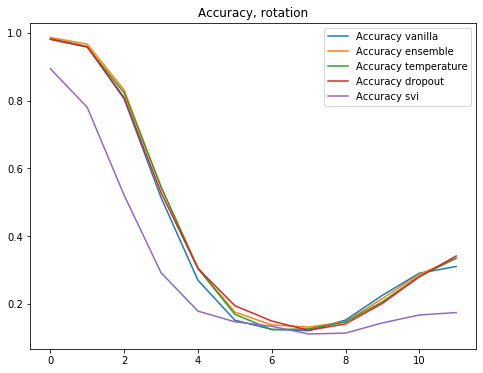

In [19]:
plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_rotate_vanilla,label="Accuracy vanilla")
ax.plot(loss_curve_rotate_ensemble,label="Accuracy ensemble")
ax.plot(loss_curve_rotate_temp,label="Accuracy temperature")
ax.plot(loss_curve_rotate_drop,label="Accuracy dropout")
ax.plot(loss_curve_rotate_svi,label="Accuracy svi")
ax.legend()
plt.title('Accuracy, rotation')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


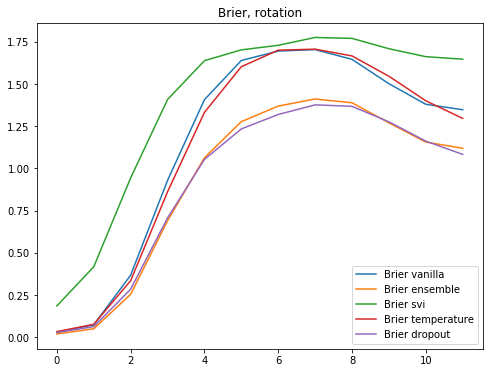

In [20]:
plt.figure(figsize=(8,6))
plt.title('Brier, rotation')
ax = plt.subplot(1,1,1)
ax.plot(brier_curve_rotate_vanilla,label="Brier vanilla")
ax.plot(brier_curve_rotate_ensemble,label="Brier ensemble")
ax.plot(brier_curve_rotate_svi,label="Brier svi")
ax.plot(brier_curve_rotate_temp,label="Brier temperature")
ax.plot(brier_curve_rotate_drop,label="Brier dropout")
ax.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


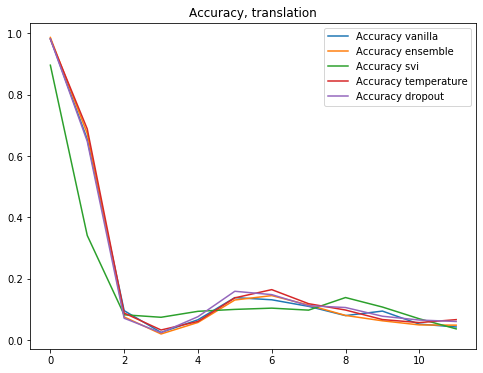

In [21]:
plt.figure(figsize=(8,6))
plt.title('Accuracy, translation')
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_translate_vanilla,label="Accuracy vanilla")
ax.plot(loss_curve_translate_ensemble,label="Accuracy ensemble")
ax.plot(loss_curve_translate_svi,label="Accuracy svi")
ax.plot(loss_curve_translate_temp,label="Accuracy temperature")
ax.plot(loss_curve_translate_drop,label="Accuracy dropout")
ax.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


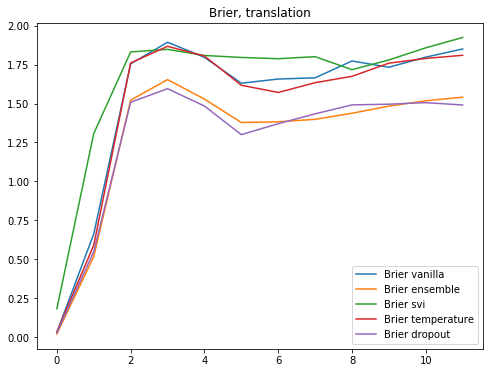

In [22]:
plt.figure(figsize=(8,6))
plt.title('Brier, translation')
ax = plt.subplot(1,1,1)
ax.plot(brier_curve_translate_vanilla,label="Brier vanilla")
ax.plot(brier_curve_translate_ensemble,label="Brier ensemble")
ax.plot(brier_curve_translate_svi,label="Brier svi")
ax.plot(brier_curve_translate_temp,label="Brier temperature")
ax.plot(brier_curve_translate_drop,label="Brier dropout")
ax.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


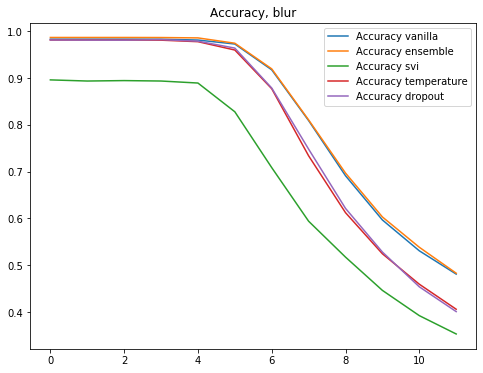

In [23]:
plt.figure(figsize=(8,6))
plt.title('Accuracy, blur')
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_blur_vanilla,label="Accuracy vanilla")
ax.plot(loss_curve_blur_ensemble,label="Accuracy ensemble")
ax.plot(loss_curve_blur_svi,label="Accuracy svi")
ax.plot(loss_curve_blur_temp,label="Accuracy temperature")
ax.plot(loss_curve_blur_drop,label="Accuracy dropout")
ax.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


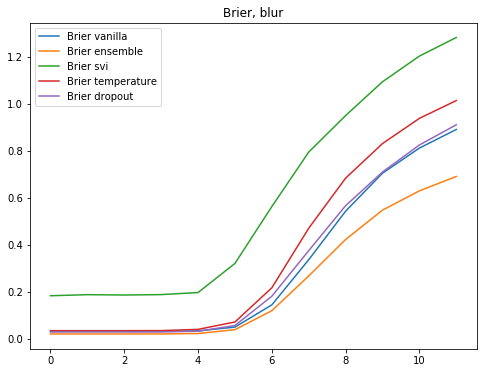

In [24]:
plt.figure(figsize=(8,6))
plt.title('Brier, blur')
ax = plt.subplot(1,1,1)
ax.plot(brier_curve_blur_vanilla,label="Brier vanilla")
ax.plot(brier_curve_blur_ensemble,label="Brier ensemble")
ax.plot(brier_curve_blur_svi,label="Brier svi")
ax.plot(brier_curve_blur_temp,label="Brier temperature")
ax.plot(brier_curve_blur_drop,label="Brier dropout")
ax.legend()
plt.show()

# Проверим энтропию предсказаний

In [25]:
cifar = fetch_openml('CIFAR_10_small')
oodX = cifar['data']
oodX = oodX.reshape((-1, 3, 32, 32))
oodX = oodX.astype('float')

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

oodX = rgb2gray(np.transpose(oodX[:,:,2:-2,2:-2], (0, 2, 3, 1))/255)
oodX = oodX.reshape((-1, 1, 28, 28))
print(oodX.shape)

(20000, 1, 28, 28)


(20000, 1, 28, 28)


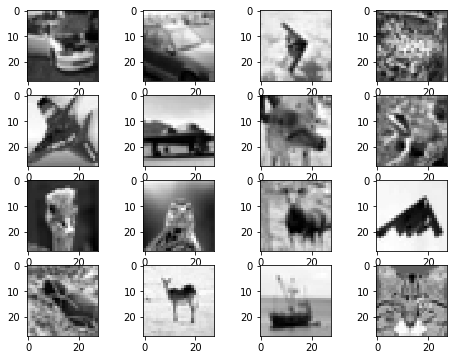

In [26]:
import scipy
plt.figure(figsize=(8,6))
print(oodX.shape)
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = oodX[np.random.randint(0, oodX.shape[0]), 0]
    #print(I.shape)
    plt.imshow(I, cmap='gray')

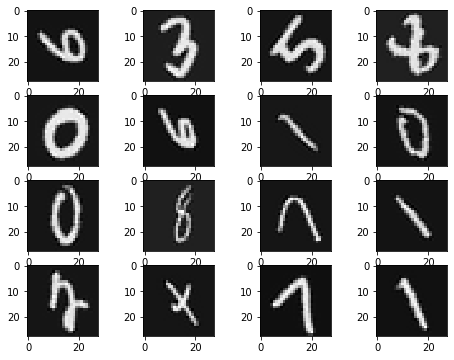

In [27]:
shiftX = scipy.ndimage.rotate(X[:oodX.shape[0], :, :, :], 50, axes=(2,3))
shiftX = shiftX[:,:, int(shiftX.shape[2]/2 - 14) : int(shiftX.shape[2]/2 + 14), int(shiftX.shape[3]/2 - 14) : int(shiftX.shape[3]/2 + 14)]
valX = X[:oodX.shape[0], :, :, :]
n=4
plt.figure(figsize=(8,6))
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = shiftX[np.random.randint(0, shiftX.shape[0]),0]
    #print(I.shape)
    plt.imshow(I, cmap='gray')

In [0]:
def entropy_van(model, x):
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    BATCH_SIZE = 25
    n_batch = x.shape[0] // BATCH_SIZE
    ent = []
    for b in range(n_batch):
        xb = torch.Tensor(x[b*BATCH_SIZE:(b + 1)*BATCH_SIZE]).to(DEVICE)
        y = scipy.special.softmax(model(xb).cpu().detach().numpy(), -1)
        ent.append(scipy.stats.entropy(y, axis=-1))
    return np.concatenate(ent)

def entropy_drop(model, x, n_iter = 10):
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    BATCH_SIZE = 25
    n_batch = x.shape[0] // BATCH_SIZE
    ent = []
    for b in range(n_batch):
        y = np.zeros((BATCH_SIZE, 10))
        xb = torch.Tensor(x[b*BATCH_SIZE:(b + 1)*BATCH_SIZE]).to(DEVICE)
        for i in range(n_iter):
            y += scipy.special.softmax(model(xb).cpu().detach().numpy(), -1)/n_iter
        ent.append(scipy.stats.entropy(y, axis=-1))
    return np.concatenate(ent)
    
def entropy_temp(model, T, x, n_iter = 10):
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    BATCH_SIZE = 25
    n_batch = x.shape[0] // BATCH_SIZE
    ent = []
    for b in range(n_batch):
        xb = torch.Tensor(x[b*BATCH_SIZE:(b + 1)*BATCH_SIZE]).to(DEVICE)
        y = scipy.special.softmax(model(xb).cpu().detach().numpy() / T, -1)
        ent.append(scipy.stats.entropy(y, axis=-1))
    return np.concatenate(ent)

def entropy_ensamble(models, x, n_iter = 10):
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    BATCH_SIZE = 25
    n_batch = x.shape[0] // BATCH_SIZE
    ent = []
    for b in range(n_batch):
        y = np.zeros((BATCH_SIZE, 10))
        xb = torch.Tensor(x[b*BATCH_SIZE:(b + 1)*BATCH_SIZE]).to(DEVICE)
        for model in models:
            y += scipy.special.softmax(model(xb).cpu().detach().numpy(), -1) / len(models)
        ent.append(scipy.stats.entropy(y, axis=-1))
    return np.concatenate(ent)

### Энтропия на валидации

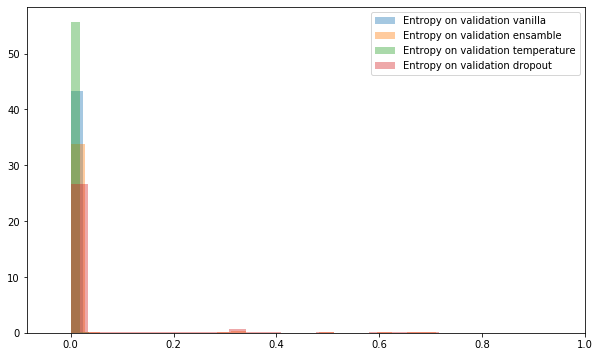

In [29]:
plt.figure(figsize=(10,6))
sns.distplot(entropy_van(model_van, valX), label='Entropy on validation vanilla', kde=False, norm_hist=True)
sns.distplot(entropy_ensamble(nets_ens, valX), label='Entropy on validation ensamble', kde=False, norm_hist=True)
sns.distplot(entropy_temp(model_temp, temperature, valX), label='Entropy on validation temperature', kde=False, norm_hist=True)
sns.distplot(entropy_drop(net_drop, valX), label='Entropy on validation dropout', kde=False, norm_hist=True)
plt.legend()
plt.xlim(right=1)
plt.show()

### Энтропия на сдвинутых данных

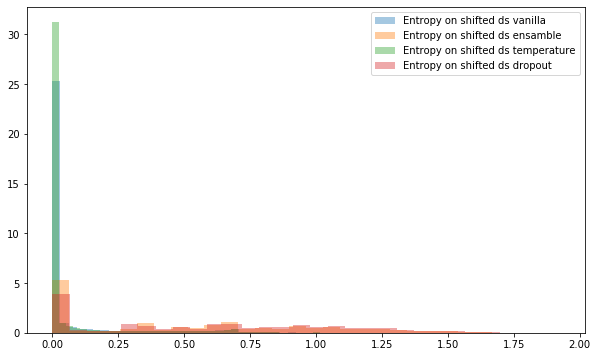

In [30]:
plt.figure(figsize=(10,6))
sns.distplot(entropy_van(model_van, shiftX), label='Entropy on shifted ds vanilla', kde=False, norm_hist=True)
sns.distplot(entropy_ensamble(nets_ens, shiftX), label='Entropy on shifted ds ensamble', kde=False, norm_hist=True)
sns.distplot(entropy_temp(model_temp,temperature, shiftX), label='Entropy on shifted ds temperature', kde=False, norm_hist=True)
sns.distplot(entropy_drop(net_drop, shiftX), label='Entropy on shifted ds dropout', kde=False, norm_hist=True)
plt.legend()
plt.show()

### OOD

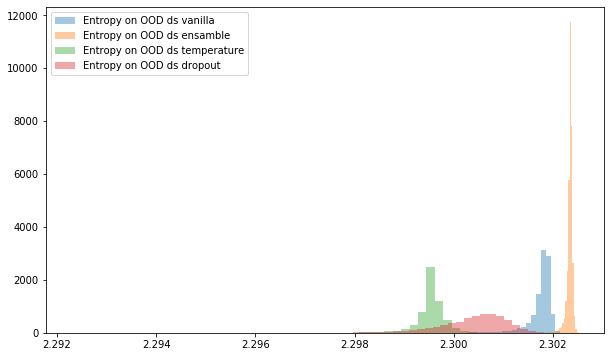

In [35]:
plt.figure(figsize=(10,6))
sns.distplot(entropy_van(model_van, oodX), label='Entropy on OOD ds vanilla', kde=False, norm_hist=True)
sns.distplot(entropy_ensamble(nets_ens, oodX), label='Entropy on OOD ds ensamble', kde=False, norm_hist=True)
sns.distplot(entropy_temp(model_temp,temperature, oodX), label='Entropy on OOD ds temperature', kde=False, norm_hist=True)
sns.distplot(entropy_drop(net_drop, oodX), label='Entropy on OOD ds dropout', kde=False, norm_hist=True)
plt.legend()
plt.show()